In [8]:
!pip install statsmodels

   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.8 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.8 MB 1.0 MB/s eta 0:00:09
   ---- ----------------------------------- 1.0/9.8 MB 1.4 MB/s eta 0:00:07
   ------ --------------------------------- 1.6/9.8 MB 1.6 MB/s eta 0:00:06
   -------- ------------------------------- 2.1/9.8 MB 1.8 MB/s eta 0:00:05
   --------- ------------------------------ 2.4/9.8 MB 1.7 MB/s eta 0:00:05
   ----------- ---------------------------- 2.9/9.8 MB 1.8 MB/s eta 0:00:04
   ------------ --------------------------- 3.1/9.8 MB 1.8 MB/s eta 0:00:04
   -------------- ------------------------- 3.7/9.8 MB 1.9 MB/s eta 0:00:04
   ----------------- ---------------------- 4.2/9.8 MB 1.9 MB/s eta 0:00:03
   ------------------ --------------------- 4.5/9.8 MB 1.9 MB/s eta 0:00:03
   -------------------- ---------

In [9]:
import numpy as np
import pandas as pd
import random
import os
import shutil
from statsmodels.tsa.arima.model import ARIMA
# import pmdarima as pm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller
import warnings

warnings.filterwarnings("ignore")

In [10]:
df = pd.DataFrame(pd.read_csv('..\\clean_data.csv',
                  parse_dates=[0]))

In [11]:
df = df.rename(columns={'target': 'y', 'date': 'ds'})
df['ds'] = pd.to_datetime(df['ds'])
df['month'] = df['ds'].dt.month

In [12]:
numeric_cols = df.select_dtypes(include='number').columns
numeric_cols.drop('y')

Index(['che_perc_gdp', 'insurance_perc_che', 'price_month', 'price_unit',
       'public_perc_che', 'month'],
      dtype='object')

In [13]:
cutoff_date = pd.to_datetime('2020-01-01')

train_data = df[df['ds'] < cutoff_date]
test_data = df[df['ds'] >= cutoff_date]

# Prepare the feature matrix and target vector for training and testing
X_train = train_data[numeric_cols.drop('y')]  # Adjust based on actual column names
y_train = train_data['y']  # Adjust based on actual column name

X_test = test_data[numeric_cols.drop('y')] # Adjust based on actual column names
y_test = test_data['y']  # Adjust based on actual column name

In [14]:
def evaluate_arima_model(x, y, arima_order):
    """Fit ARIMA model and calculate AIC on the given data."""
    try:
        model = ARIMA(y, exog=x, order=arima_order)
        model_fit = model.fit()
        aic = model_fit.aic
        return aic
    except Exception as e:
        return np.inf

def optimize_arima(parameters_list, x, y):
    """Return the best ARIMA model parameters based on AIC."""
    results = []
    best_aic = np.inf
    best_order = None
    
    for parameters in parameters_list:
        aic = evaluate_arima_model(x, y, parameters)
        if aic < best_aic:
            best_aic = aic
            best_order = parameters
        results.append((parameters, aic))
    
    results = sorted(results, key=lambda x: x[1])
    return best_order, results

In [15]:
# Parameters to try
p_values = range(0, 4)
d_values = range(0, 3) # Based on the above test
q_values = range(0, 4)
parameters = [(p, d, q) for p in p_values for d in d_values for q in q_values]

# Finding the best ARIMA model
best_order, results = optimize_arima(parameters, X_train, y_train)
print('Best ARIMA order:', best_order)
print('AIC values for different orders:', results)

Best ARIMA order: (3, 1, 1)
AIC values for different orders: [((3, 1, 1), np.float64(158296.1751743683)), ((0, 1, 1), np.float64(158300.02868780372)), ((1, 1, 1), np.float64(158301.73491434357)), ((0, 1, 2), np.float64(158301.73758279954)), ((2, 1, 1), np.float64(158302.42163110158)), ((0, 1, 3), np.float64(158302.467040073)), ((1, 1, 2), np.float64(158302.7203326985)), ((3, 1, 2), np.float64(158304.33550036047)), ((2, 1, 2), np.float64(158304.73856038586)), ((1, 1, 3), np.float64(158304.91726016524)), ((2, 1, 3), np.float64(158307.63532739956)), ((3, 0, 3), np.float64(158308.22545283433)), ((3, 1, 3), np.float64(158308.89092646714)), ((2, 0, 3), np.float64(158313.828245213)), ((2, 0, 2), np.float64(158315.01648540224)), ((3, 0, 2), np.float64(158315.7922249747)), ((1, 2, 3), np.float64(158340.442748953)), ((1, 0, 1), np.float64(158363.19180604687)), ((1, 0, 3), np.float64(158364.951717933)), ((1, 0, 2), np.float64(158390.05086627533)), ((2, 0, 1), np.float64(158400.08138355403)), ((3,

In [17]:
model = ARIMA(y_train, order=best_order)
fitted_model = model.fit()

In [18]:
steps = len(y_test)
y_pred = fitted_model.forecast(steps=steps)

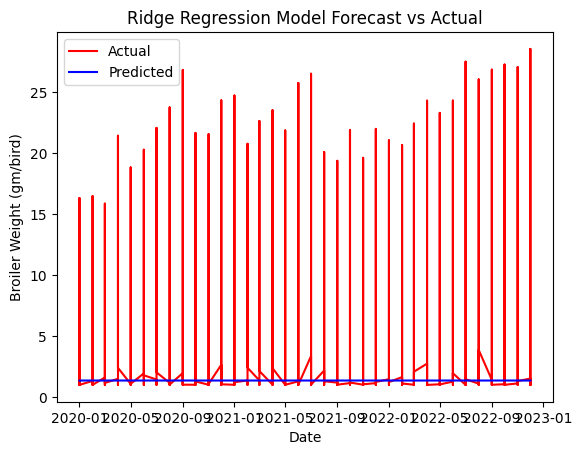

In [19]:
import matplotlib.pyplot as plt

plt.plot(test_data['ds'], y_test, label='Actual', color='red')
plt.plot(test_data['ds'], y_pred, label='Predicted', color='blue')
plt.legend()
plt.title('Ridge Regression Model Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Broiler Weight (gm/bird)')
plt.show()